## 중간층의 활성화 시각화하기
> 중간층의 활성화 시각화는 어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성맵을 그리는 것이다(**활성화**라고도 부른다). 이 방법은 네트워크에 의해 학습된 필터들이 어떻게 입력을 분해하는지 보여준다. 너비, 높이, 깊이(채널) 3개의 차원에 대해 특성 맵을 시각화 하는 것이 좋다.
### 모델 로드하기

In [1]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5',compile = False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### 개별 이미지 전처리 하기

In [4]:
img_path = './datasets/train/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4D텐서로 변경한다.
img_tensor /= 255. # 모델이 훈련될 때 입력에 전처리 방식을 동일하게 사용한다.

print(img_tensor.shape) # 이미지 텐서의 크기는 (1, 150, 150, 3)이다.

(1, 150, 150, 3)


### 테스트 사진 출력하기

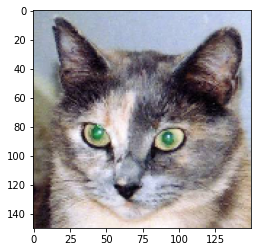

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()